# Imports

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import os
import seaborn as sns
from glob import glob
from collections import OrderedDict
import ipaddress
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


##Generate Data Set

In [27]:
def random_private_ip():
    first_octet = np.random.choice([10, 172, 192])
    if first_octet == 10:
        return f"10.{np.random.randint(0, 256)}.{np.random.randint(0, 256)}.{np.random.randint(0, 256)}"
    elif first_octet == 172:
        return f"172.{np.random.randint(16, 32)}.{np.random.randint(0, 256)}.{np.random.randint(0, 256)}"
    elif first_octet == 192:
        return f"192.168.{np.random.randint(0, 256)}.{np.random.randint(0, 256)}"

def random_public_ip():
    while True:
        ip = f"{np.random.randint(1, 256)}.{np.random.randint(0, 256)}.{np.random.randint(0, 256)}.{np.random.randint(0, 256)}"
        first_octet = int(ip.split('.')[0])
        if first_octet not in [10, 172, 192]:  # Ensure it's not in private range
            return ip

def random_port():
    return np.random.randint(1, 65536)

def random_protocol():
    return np.random.choice(['TCP', 'UDP'])
    
def ip_to_numeric(ip):
    return [int(octet) for octet in ip.split('.')]

In [17]:
# Number of connections
num_connections = 1000000
private_dst_ratio = 0.20
private_dst_count = int(num_connections * private_dst_ratio)
public_dst_count = num_connections - private_dst_count

# Generate srcIp as always private
src_ips = [random_private_ip() for _ in range(num_connections)]

dst_ips = ([random_private_ip() for _ in range(private_dst_count)] + 
           [random_public_ip() for _ in range(public_dst_count)])
np.random.shuffle(dst_ips)  # Shuffle to mix private and public IPs

src_ports = [random_port() for _ in range(num_connections)]
dst_ports = [random_port() for _ in range(num_connections)]
protocols = [random_protocol() for _ in range(num_connections)]

# Create the DataFrame
data = {
    'srcIp': src_ips,
    'srcPort': src_ports,
    'protocol': protocols,
    'dstIP': dst_ips,
    'dstPort': dst_ports,
}

df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df.head()
print (df)


                 srcIp  srcPort protocol            dstIP  dstPort
0        10.165.44.243    26321      UDP     48.29.153.17    54333
1         172.28.167.9    31288      UDP     217.91.33.63    50397
2         172.21.36.39    45169      TCP    192.168.3.117    57479
3       10.149.104.117    34824      TCP  192.168.125.142    40273
4       10.161.228.139     5517      TCP    148.23.101.84    18448
...                ...      ...      ...              ...      ...
999995  172.31.197.243     4066      TCP    172.28.39.120     5999
999996  192.168.169.48    22796      TCP    196.13.144.35    38740
999997    172.22.39.47    39128      TCP  192.168.120.100    44553
999998    172.21.69.36    55153      TCP  201.128.144.150    62765
999999  192.168.98.250    18792      TCP     77.71.244.86    18415

[1000000 rows x 5 columns]


In [23]:
#verify that there are dulications 
src_ip_counts = df['srcIp'].value_counts()
dst_ip_counts = df['dstIP'].value_counts()
duplicate_src_ips = src_ip_counts[src_ip_counts > 5]
duplicate_dst_ips = dst_ip_counts[dst_ip_counts > 5]

print (duplicate_src_ips)
duplicate_dst_ips



srcIp
192.168.113.16     19
192.168.138.140    17
192.168.235.108    16
192.168.239.160    16
192.168.106.248    16
                   ..
192.168.121.67      6
192.168.100.120     6
192.168.84.71       6
192.168.248.244     6
192.168.34.100      6
Name: count, Length: 26297, dtype: int64


dstIP
192.168.64.230     8
192.168.214.67     7
192.168.213.42     6
192.168.63.85      6
192.168.171.37     6
192.168.91.131     6
192.168.122.167    6
192.168.119.167    6
192.168.190.172    6
192.168.185.195    6
192.168.170.19     6
192.168.239.49     6
192.168.12.151     6
192.168.121.39     6
192.168.50.179     6
192.168.20.170     6
192.168.7.48       6
192.168.145.231    6
192.168.140.87     6
192.168.119.6      6
192.168.52.34      6
192.168.28.206     6
192.168.84.38      6
192.168.149.75     6
192.168.36.84      6
192.168.39.66      6
192.168.155.221    6
192.168.212.11     6
192.168.216.115    6
192.168.20.109     6
192.168.221.8      6
192.168.53.186     6
192.168.116.254    6
192.168.50.253     6
192.168.236.251    6
192.168.32.184     6
192.168.180.115    6
192.168.40.128     6
192.168.99.151     6
192.168.245.119    6
192.168.178.77     6
192.168.8.129      6
192.168.75.36      6
Name: count, dtype: int64

In [31]:
# Convert srcIp to numerical format
src_ip_numerical = df['srcIp'].apply(ip_to_numeric)
src_ip_numerical = np.array(src_ip_numerical.tolist())
#df.dtypes

srcIp       object
srcPort      int64
protocol    object
dstIP       object
dstPort      int64
dtype: object

In [32]:
df

,srcIp,srcPort,protocol,dstIP,dstPort
0,10.165.44.243,26321,UDP,48.29.153.17,54333
1,172.28.167.9,31288,UDP,217.91.33.63,50397
2,172.21.36.39,45169,TCP,192.168.3.117,57479
3,10.149.104.117,34824,TCP,192.168.125.142,40273
4,10.161.228.139,5517,TCP,148.23.101.84,18448
...,...,...,...,...,...
999995,172.31.197.243,4066,TCP,172.28.39.120,5999
999996,192.168.169.48,22796,TCP,196.13.144.35,38740
999997,172.22.39.47,39128,TCP,192.168.120.100,44553
999998,172.21.69.36,55153,TCP,201.128.144.150,62765


In [34]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(src_ip_numerical)
df['srcIp_cluster'] = kmeans.labels_
df.head()



d:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,srcIp,srcPort,protocol,dstIP,dstPort,srcIp_cluster
0,10.165.44.243,26321,UDP,48.29.153.17,54333,2
1,172.28.167.9,31288,UDP,217.91.33.63,50397,3
2,172.21.36.39,45169,TCP,192.168.3.117,57479,0
3,10.149.104.117,34824,TCP,192.168.125.142,40273,2
4,10.161.228.139,5517,TCP,148.23.101.84,18448,2


In [52]:
cluster_4_ips = df[df['srcIp_cluster'] == 1]['srcIp']
cluster_4_ips

6          192.168.169.40
7         192.168.121.130
12         192.168.37.204
16        192.168.233.183
21        192.168.147.134
               ...       
999982    192.168.203.160
999989      192.168.92.73
999992    192.168.145.172
999996     192.168.169.48
999999     192.168.98.250
Name: srcIp, Length: 333557, dtype: object

In [48]:
df_g = df.groupby('srcIp_cluster')
df_g
#df

d:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


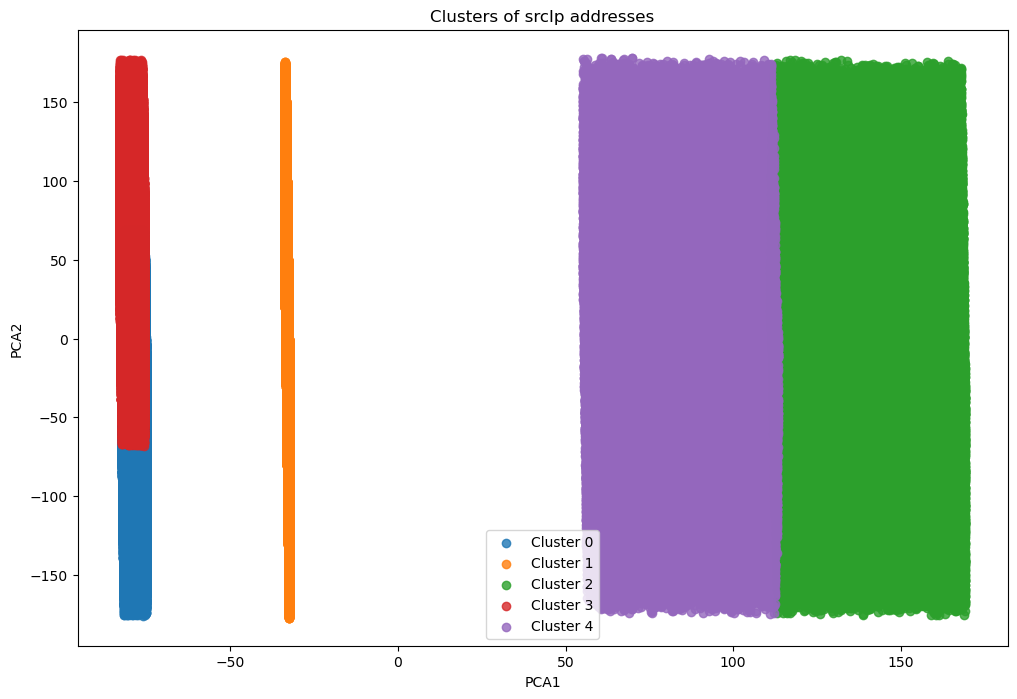

In [38]:
pca = PCA(n_components=2)
ip_pca = pca.fit_transform(src_ip_numerical)
pca_df = pd.DataFrame(ip_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = kmeans.labels_
plt.figure(figsize=(12, 8))
for cluster in range(num_clusters):
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}', alpha=0.8)

plt.title('Clusters of srcIp addresses')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()
